<a href="https://colab.research.google.com/github/sajiaakhter/mec-mini-projects/blob/master/mec_17_4_1_recommendation_systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**2: Import Necessary Dependencies**

In [2]:
# filter out unncessary warnings
import warnings
warnings.filterwarnings('ignore')

# To store\load the data
import pandas as pd

# To do linear algebra
import numpy as np

# To create plots
import matplotlib.pyplot as plt
import seaborn as sns


# To compute similarities between vectors
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# data load progress bars
from tqdm import tqdm

from collections import deque

# To create deep learning models
import tensorflow as tf
import keras
from keras.layers import Input, Embedding, Reshape, Dot, Concatenate, Dense, Dropout
from keras.models import Model

# To stack sparse matrices
from scipy.sparse import vstack

# remove unnecessary TF logs
import logging
tf.get_logger().setLevel(logging.ERROR)

# check keras and TF version used
print('TF Version:', tf.__version__)
print('Keras Version:', keras.__version__)





TF Version: 2.9.2
Keras Version: 2.9.0


**3. Load Datasets**


In [3]:
filename = "/content/sample_data/movie_titles.csv.zip"
filenameMeta = "/content/sample_data/movies_metadata.csv.zip"

# 3.1: Load Movie Metadata Datasets
movie_titles = pd.read_csv(filename, 
                           encoding = 'ISO-8859-1', 
                           header = None, 
                           names = ['Id', 'Year', 'Name']).set_index('Id')

print('Shape Movie-Titles:\t{}'.format(movie_titles.shape))
movie_titles.sample(5)


Shape Movie-Titles:	(17770, 2)


,Year,Name
Id,,
8313,1977.0,The Many Adventures of Winnie the Pooh
8130,2000.0,Gothic Industrial Madness
5403,1999.0,Light It Up
11998,1978.0,Convoy
1390,2005.0,Ben Franklin


In [4]:
# Load a movie metadata dataset
movie_metadata = (pd.read_csv(filenameMeta, low_memory=False)[['original_title', 'overview', 'vote_count']].set_index('original_title').dropna())

# Remove the long tail of rarly rated moves
movie_metadata = movie_metadata[movie_metadata['vote_count']>10].drop('vote_count', axis=1)

print('Shape Movie-Metadata:\t{}'.format(movie_metadata.shape))
movie_metadata.sample(5)

Shape Movie-Metadata:	(21604, 1)


,overview
original_title,
Jing wu ying xiong,"Chen Zhen, a Chinese engineering student in Ky..."
Drums Along the Mohawk,"Set in America's Colonial period, John Ford's ..."
The Marrying Man,"Charley Pearl, wealthy heir and gadabout, is s..."
Albatross,"Beth, a bookish teenager, befriends Emilia, an..."
Here Comes Mr. Jordan,"Boxer Joe Pendleton, flying to his next fight,..."


**3.2: Load User-Movie-Rating Dataset**

In [ ]:
# Dowload large file from the shared GDrive folder
!pip install gdown
!gdown "https://drive.google.com/uc?export=download&id=1z0O0fXuofdsbpL8fkCVgjeIwFP_LxGX2" -O data/

In [6]:
# Load single data-file
df_raw = pd.read_csv('/content/data/combined_data.csv.zip', 
                     header=None, 
                     names=['User', 'Rating', 'Date'], 
                     usecols=[0, 1, 2])

# Find empty rows to slice dataframe for each movie
tmp_movies = df_raw[df_raw['Rating'].isna()]['User'].reset_index()
movie_indices = [[index, int(movie[:-1])] for index, movie in tmp_movies.values]

# Shift the movie_indices by one to get start and endpoints of all movies
shifted_movie_indices = deque(movie_indices)
shifted_movie_indices.rotate(-1)

# Gather all dataframes
user_data = []

# Iterate over all movies
for [df_id_1, movie_id], [df_id_2, next_movie_id] in zip(movie_indices, shifted_movie_indices):
    
    # Check if it is the last movie in the file
    if df_id_1<df_id_2:
        tmp_df = df_raw.loc[df_id_1+1:df_id_2-1].copy()
    else:
        tmp_df = df_raw.loc[df_id_1+1:].copy()
        
    # Create movie_id column
    tmp_df['Movie'] = movie_id
    
    # Append dataframe to list
    user_data.append(tmp_df)

# Combine all dataframes
df = pd.concat(user_data)
del user_data, df_raw, tmp_movies, tmp_df, shifted_movie_indices, movie_indices, df_id_1, movie_id, df_id_2, next_movie_id
print('Shape User-Ratings:\t{}'.format(df.shape))
df.sample(10)

Shape User-Ratings:	(24053764, 4)


,User,Rating,Date,Movie
14005971,163896,5.0,2005-06-02,2690
1135002,1297347,5.0,2004-01-06,257
17513415,1456829,3.0,2003-09-27,3365
3304334,1431342,1.0,2004-09-28,607
6748522,2506128,4.0,2005-01-27,1307
5845664,1433108,4.0,2005-09-26,1145
8316613,81922,1.0,2002-01-07,1656
23271095,289614,4.0,2005-04-22,4356
3267854,2160091,2.0,2005-07-13,607
4133046,968595,5.0,2005-03-24,789


**4. Exploratory Data Analysis**

4.1: When were the movies released?


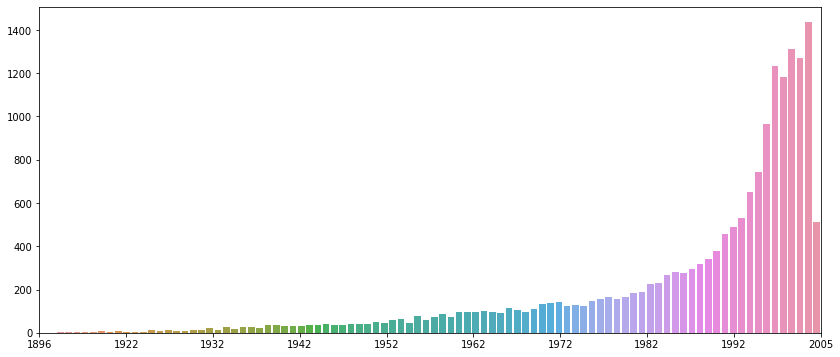

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

data = movie_titles['Year'].value_counts().sort_index()
x = data.index.map(int)
y = data.values

sns.barplot(x, y)
xmin, xmax = plt.xlim()
xtick_labels = [x[0]] + list(x[10:-10:10]) + [x[-1]]
plt.xticks(ticks=np.linspace(xmin, xmax, 10), labels=xtick_labels);

Q 4.2: How are The Ratings Distributed?


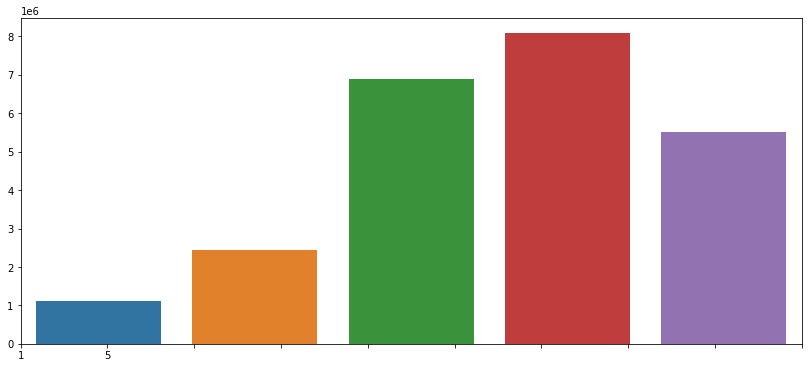

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

data = df['Rating'].value_counts().sort_index()
x = data.index.map(int)
y = data.values

sns.barplot(x, y)
xmin, xmax = plt.xlim()
xtick_labels = [x[0]] + list(x[10:-10:10]) + [x[-1]]
plt.xticks(ticks=np.linspace(xmin, xmax, 10), labels=xtick_labels); 

**4.3: Visualize the Distribution of Number of Movie Ratings**

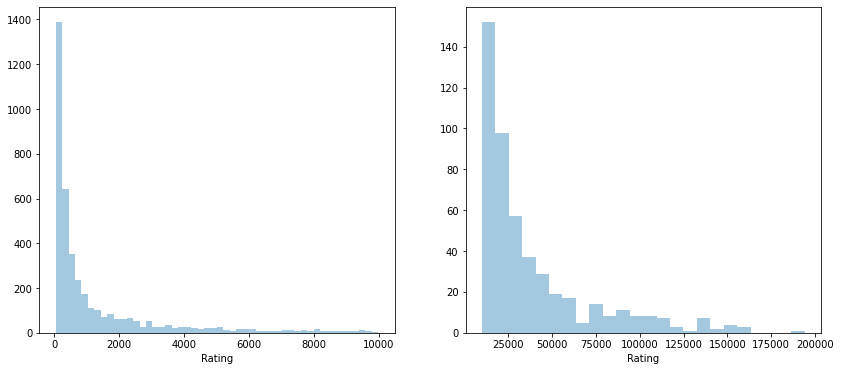

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

data = df.groupby('Movie')['Rating'].count()
sns.distplot(data[data  < 10000], kde=False, ax=ax[0]);
sns.distplot(data[data  > 10000], kde=False, ax=ax[1]);


**Q 4.4: Visualize the Distribution of Number of User Ratings**

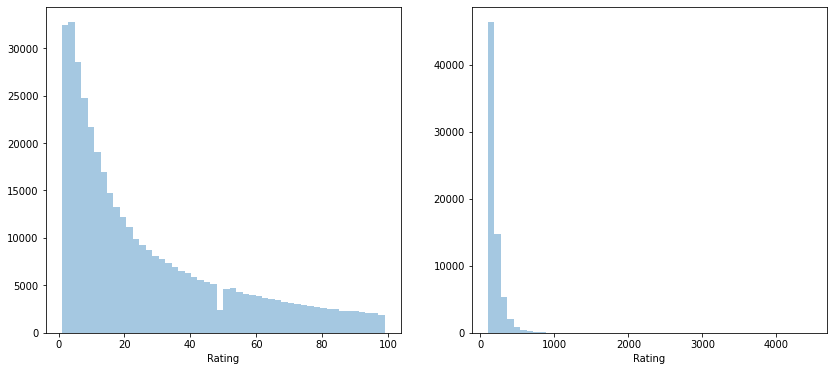

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

data = df.groupby('User')['Rating'].count()
sns.distplot(data[data  < 100], kde=False, ax=ax[0]);
sns.distplot(data[data  > 100], kde=False, ax=ax[1]);


**5. Dimensionality Reduction & Filtering**
Filter Sparse Movies And Users

In [11]:
# Filter sparse movies
min_movie_ratings = 1000
filter_movies = (df['Movie'].value_counts()>min_movie_ratings)
filter_movies = filter_movies[filter_movies].index.tolist()

# Filter sparse users
min_user_ratings = 200
filter_users = (df['User'].value_counts()>min_user_ratings)
filter_users = filter_users[filter_users].index.tolist()

# Actual filtering
df_filtered = df[(df['Movie'].isin(filter_movies)) & (df['User'].isin(filter_users))]
del filter_movies, filter_users, min_movie_ratings, min_user_ratings
print('Shape User-Ratings unfiltered:\t{}'.format(df.shape))
print('Shape User-Ratings filtered:\t{}'.format(df_filtered.shape))

Shape User-Ratings unfiltered:	(24053764, 4)
Shape User-Ratings filtered:	(5930581, 4)


**6. Create Train and Test Datasets**


In [12]:
# Shuffle DataFrame
df_filtered = df_filtered.drop('Date', axis=1).sample(frac=1).reset_index(drop=True)

# Testingsize
n = 100000

# Split train- & testset
df_train = df_filtered[:-n]
df_test = df_filtered[-n:]
df_train.shape, df_test.shape
#df_train.head(10)


((5830581, 3), (100000, 3))

In [13]:
df_test.head(5)

,User,Rating,Movie
5830581,712653,3.0,3650
5830582,2259598,3.0,3239
5830583,2200718,4.0,3684
5830584,1252263,4.0,30
5830585,2460074,3.0,1307


**7. Transformation**

Q 7.1: Transform The User-Movie-Ratings Data Frame to User-Movie Matrix

In [14]:
# Create a user-movie matrix with empty values
df_train.head(10)
df_p = pd.pivot_table(df_train, index=df_train['User'], columns=df_train['Movie'])
print('Shape User-Movie-Matrix:\t{}'.format(df_p.shape))
df_p.head(10)


Shape User-Movie-Matrix:	(20828, 1741)


Rating                                               ...            \
Movie     3    5    6    8    16   17   18   24   25   26    ... 4482 4483   
User                                                         ...             
1000079    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
1000192    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
1000301    NaN  NaN  NaN  NaN  NaN  NaN  4.0  NaN  NaN  NaN  ...  NaN  NaN   
1000387    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
1000410    NaN  NaN  NaN  NaN  NaN  NaN  4.0  NaN  NaN  NaN  ...  NaN  NaN   
1000527    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
1000596    NaN  NaN  NaN  NaN  NaN  NaN  NaN  2.0  NaN  NaN  ...  NaN  NaN   
1000634    NaN  NaN  NaN  NaN  3.0  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
1000710    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
1000779    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   

                                                 
Movie   4484 4485 4488 4489 4490 4492 4493 4496  
User                                             
1000079  NaN  NaN  2.0  NaN  NaN  NaN  NaN  NaN  
1000192  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
1000301  NaN  NaN  4.0  NaN  NaN  NaN  NaN  NaN  
1000387  NaN  1.0  2.0  NaN  NaN  1.0  NaN  NaN  
1000410  NaN  NaN  3.0  NaN  3.0  NaN  NaN  3.0  
1000527  NaN  NaN  NaN  NaN  NaN  NaN  3.0  NaN  
1000596  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
1000634  NaN  NaN  4.0  NaN  NaN  4.0  NaN  NaN  
1000710  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
1000779  NaN  NaN  NaN  NaN  NaN  NaN  NaN  4.0  

[10 rows x 1741 columns]

**8. Building Recommendation Systems
8.1(a): Global Recommendation Systems (Mean Rating)**

In [15]:
ratings_mean = df_p.mean(axis=0).sort_values(ascending=False).rename('Rating-Mean').to_frame()
print(ratings_mean)
# Compute rating frequencies for all movies
ratings_count = df_p.count(axis=0).rename('Rating-Freq').to_frame()
#ratings_count.head(10)

# Combine the aggregated dataframes
combined_df_temp = ratings_mean.join(ratings_count)
combined_df = combined_df_temp.set_index(combined_df_temp.index.levels[1]).join(movie_titles)
combined_df.head(5)


              Rating-Mean
       Movie             
Rating 3456      4.655277
       2102      4.507885
       3444      4.435185
       2452      4.425460
       2172      4.387973
...                   ...
       3505      2.095259
       2276      2.008210
       3021      1.976796
       4394      1.962366
       3667      1.702602

[1741 rows x 1 columns]


,Rating-Mean,Rating-Freq,Year,Name
Movie,,,,
3,4.655277,1317,1997.0,Character
5,4.507885,2790,2004.0,The Rise and Fall of ECW
6,4.435185,2808,1997.0,Sick
8,4.425460,18594,2004.0,What the #$*! Do We Know!?
16,4.387973,6186,1996.0,Screamers


In [16]:
# Join labels and predictions based on mean movie rating
predictions_df = df_test.set_index('Movie').join(ratings_mean.set_index(ratings_mean.index.levels[1]))
predictions_df.head(5)

,User,Rating,Rating-Mean
Movie,,,
3,1598669,3.0,4.655277
3,939439,4.0,4.655277
3,163515,4.0,4.655277
3,2496050,4.0,4.655277
3,873713,1.0,4.655277


In [17]:
# Compute RMSE
y_true = predictions_df['Rating']
y_pred = predictions_df['Rating-Mean']

rmse = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_pred))
print("The RMSE Value for the Mean Rating Recommender:", rmse)


The RMSE Value for the Mean Rating Recommender: 1.1454801587375176


In [18]:
# View top ten rated movies
combined_df[['Name', 'Rating-Mean']].head(10)

,Name,Rating-Mean
Movie,,
3,Character,4.655277
5,The Rise and Fall of ECW,4.507885
6,Sick,4.435185
8,What the #$*! Do We Know!?,4.425460
16,Screamers,4.387973
17,7 Seconds,4.369602
18,Immortal Beloved,4.367451
24,My Bloody Valentine,4.353211
25,Inspector Morse 31: Death Is Now My Neighbour,4.346288


**Q 8.1(b): Global Recommendation Systems (Weighted Rating)**

In [19]:
# Number of minimum votes to be considered
m = 1000

# Mean rating for all movies
C = df_p.stack().mean()

# Mean rating for all movies separately
R = df_p.mean(axis=0).values

# Rating freqency for all movies separately
v = df_p.count().values

In [20]:
# Weighted formula to compute the weighted rating
#weighted rating (𝑊𝑅)=(𝑣/(𝑣+𝑚))𝑅+(𝑚/(𝑣+𝑚))𝐶
weighted_score = ((v/(v+m))*R+(m/(v+m))*C.values[0])
print(weighted_score)

[3.46447828 3.45404166 3.38441904 ... 2.91382642 3.26427912 3.62802051]


In [21]:
print(df_p.columns.levels[1])

Int64Index([   3,    5,    6,    8,   16,   17,   18,   24,   25,   26,
            ...
            4482, 4483, 4484, 4485, 4488, 4489, 4490, 4492, 4493, 4496],
           dtype='int64', name='Movie', length=1741)


In [22]:
# convert weighted_score into a dataframe
weighted_mean = pd.DataFrame(weighted_score, index = df_p.columns.levels[1],columns=["weighted mean"])
weighted_mean.head(5)

# Combine the aggregated dataframes (wighted_mean & movie_titles)
combined_df = weighted_mean.join(movie_titles)
combined_df.head(5)

,weighted mean,Year,Name
Movie,,,
3,3.464478,1997.0,Character
5,3.454042,2004.0,The Rise and Fall of ECW
6,3.384419,1997.0,Sick
8,3.168845,2004.0,What the #$*! Do We Know!?
16,3.191963,1996.0,Screamers


In [23]:
# Join labels and predictions based on mean movie rating
predictions_df = df_test.set_index('Movie').join(weighted_mean)
predictions_df.head(5)



,User,Rating,weighted mean
Movie,,,
3,1598669,3.0,3.464478
3,939439,4.0,3.464478
3,163515,4.0,3.464478
3,2496050,4.0,3.464478
3,873713,1.0,3.464478


In [24]:
# Compute RMSE

y_true = predictions_df['Rating']
y_pred = predictions_df['weighted mean']

rmse = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_pred))

print("The RMSE Value for the Weighted-Mean Rating Recommender:", rmse)


The RMSE Value for the Weighted-Mean Rating Recommender: 1.0077502515692365


In [25]:
# View top ten rated movies
combined_df[['Name', 'weighted mean']].head(10)

,Name,weighted mean
Movie,,
3,Character,3.464478
5,The Rise and Fall of ECW,3.454042
6,Sick,3.384419
8,What the #$*! Do We Know!?,3.168845
16,Screamers,3.191963
17,7 Seconds,3.171597
18,Immortal Beloved,3.641913
24,My Bloody Valentine,3.230422
25,Inspector Morse 31: Death Is Now My Neighbour,3.536693


**8.2: Content Based Recommendation Systems**

In [26]:
# view sample movie descriptions
movie_metadata['overview'].head(5)

original_title
Toy Story                      Led by Woody, Andy's toys live happily in his ...
Jumanji                        When siblings Judy and Peter discover an encha...
Grumpier Old Men               A family wedding reignites the ancient feud be...
Waiting to Exhale              Cheated on, mistreated and stepped on, the wom...
Father of the Bride Part II    Just when George Banks has recovered from his ...
Name: overview, dtype: object

In [27]:
# Create tf-idf matrix for text comparison
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movie_metadata['overview'])

In [28]:
# Compute cosine similarity between all movie-descriptions
similarity = cosine_similarity(tfidf_matrix)
similarity_df = pd.DataFrame(similarity, 
                             index=movie_metadata.index.values, 
                             columns=movie_metadata.index.values)
similarity_df.head(10)

,Toy Story,Jumanji,Grumpier Old Men,Waiting to Exhale,Father of the Bride Part II,Heat,Sabrina,Tom and Huck,Sudden Death,GoldenEye,...,The Final Storm,In a Heartbeat,"Bloed, Zweet en Tranen",To Be Fat Like Me,Cadet Kelly,L'Homme à la tête de caoutchouc,Le locataire diabolique,L'Homme orchestre,Maa,Robin Hood
Toy Story,1.000000,0.015385,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.023356,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
Jumanji,0.015385,1.000000,0.046854,0.000000,0.000000,0.047646,0.000000,0.000000,0.098488,0.0,...,0.000000,0.000000,0.0,0.004192,0.0,0.014642,0.000000,0.000000,0.000000,0.0
Grumpier Old Men,0.000000,0.046854,1.000000,0.000000,0.023903,0.000000,0.000000,0.006463,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.015409,0.000000,0.000000,0.007101,0.0
Waiting to Exhale,0.000000,0.000000,0.000000,1.000000,0.000000,0.007417,0.000000,0.008592,0.000000,0.0,...,0.028460,0.000000,0.0,0.000000,0.0,0.000000,0.016324,0.006840,0.000000,0.0
Father of the Bride Part II,0.000000,0.000000,0.023903,0.000000,1.000000,0.000000,0.030866,0.000000,0.033213,0.0,...,0.000000,0.000000,0.0,0.022816,0.0,0.000000,0.000000,0.000000,0.012584,0.0
Heat,0.000000,0.047646,0.000000,0.007417,0.000000,1.000000,0.000000,0.000000,0.046349,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.015837,0.000000,0.000000,0.0
Sabrina,0.000000,0.000000,0.000000,0.000000,0.030866,0.000000,1.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.028344,0.0,0.000000,0.105139,0.000000,0.000000,0.0
Tom and Huck,0.000000,0.000000,0.006463,0.008592,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,...,0.164136,0.071019,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.006162,0.0
Sudden Death,0.000000,0.098488,0.000000,0.000000,0.033213,0.046349,0.000000,0.000000,1.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.014963,0.0
GoldenEye,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,...,0.043867,0.000000,0.0,0.000000,0.0,0.076444,0.000000,0.016266,0.000000,0.0


In [29]:
# movie list 
movie_list = similarity_df.columns.values


# sample movie
movie = 'Batman Begins'

# top recommendation movie count
top_n = 10

# get movie similarity records
movie_sim = similarity_df[similarity_df.index == movie].values[0]

# get movies sorted by similarity
sorted_movie_ids = np.argsort(movie_sim)[::-1]

# get recommended movie names
recommended_movies = movie_list[sorted_movie_ids[1:top_n+1]]

print('\n\nTop Recommended Movies for:', movie, 'are:-\n', recommended_movies)



Top Recommended Movies for: Batman Begins are:-
 ['Batman Unmasked: The Psychology of the Dark Knight'
 'Batman: The Dark Knight Returns, Part 1' 'Batman: Bad Blood'
 'Batman: Year One' 'Batman: Under the Red Hood'
 'Batman Beyond: The Movie' 'Batman Forever'
 'Batman: Mask of the Phantasm' 'Batman & Bill' 'Batman']


**Create a function as defined below, content_movie_recommender() which can take in sample movie names and print a list of top N recommended movies**

In [30]:
def content_movie_recommender(input_movie, similarity_database=similarity_df, movie_database_list=movie_list, top_n=10):
  
  # get movie similarity records
  movie_sim = similarity_df[similarity_df.index == input_movie].values[0]

  # get movies sorted by similarity
  sorted_movie_ids = np.argsort(movie_sim)[::-1]

  # get recommended movie names
  recommended_movies = movie_list[sorted_movie_ids[1:top_n+1]]

  return recommended_movies



In [31]:
sample_movies = ['Captain America', 'The Terminator', 'The Exorcist', 
                 'The Hunger Games: Mockingjay - Part 1', 'The Blair Witch Project']
# movie list 
movie_list = similarity_df.columns.values

for m in sample_movies:
  reco = content_movie_recommender(m, similarity_df, movie_list, 10)
  print('\n\nTop Recommended Movies for:', movie, 'are:-\n', reco)



Top Recommended Movies for: Batman Begins are:-
 ['Iron Man & Captain America: Heroes United'
 'Captain America: The First Avenger' 'Team Thor' 'Education for Death'
 'Captain America: The Winter Soldier' '49th Parallel' 'Ultimate Avengers'
 'Philadelphia Experiment II' 'Vice Versa' 'The Lair of the White Worm']


Top Recommended Movies for: Batman Begins are:-
 ['Terminator 2: Judgment Day' 'Terminator Salvation'
 'Terminator 3: Rise of the Machines' 'Silent House' 'They Wait'
 'Another World' 'Teenage Caveman' 'Appleseed Alpha' 'Respire'
 'Just Married']


Top Recommended Movies for: Batman Begins are:-
 ['Exorcist II: The Heretic' 'Domestic Disturbance' 'Damien: Omen II'
 'The Exorcist III' 'Like Sunday, Like Rain' 'People Like Us'
 'Quand on a 17 Ans' "Don't Knock Twice" 'Zero Day' 'Brick Mansions']


Top Recommended Movies for: Batman Begins are:-
 ['The Hunger Games: Catching Fire' 'The Hunger Games: Mockingjay - Part 2'
 'Last Train from Gun Hill' 'The Hunger Games'
 'Will Suc

**8.3: Collaborative filtering Recommendation Systems**
Collaborative Filtering


Q8.3: Building a Deep Learning Matrix Factorization based Collaborative Filtering Recommendation System


In [32]:
# Create user and movie-id mapping to convert to numbers
user_id_mapping = {id:i for i, id in enumerate(df_filtered['User'].unique())}
movie_id_mapping = {id:i for i, id in enumerate(df_filtered['Movie'].unique())}

In [33]:
# use dataframe map function to map users & movies to mapped ids based on above mapping
train_user_data = df_train['User'].map(user_id_mapping)
train_movie_data = df_train['Movie'].map(movie_id_mapping)

In [34]:
# do the same for test data
test_user_data = df_test['User'].map(user_id_mapping)
test_movie_data = df_test['Movie'].map(movie_id_mapping)


In [35]:
# Get input variable-sizes
users = len(user_id_mapping)
movies = len(movie_id_mapping)
embedding_size = 100

**Construct Deep Learning Model Architecture**

In [ ]:
# use Input() to create tensors for - 'user' and 'movie'
user_id_input = Input(shape=(1,), name='user')
movie_id_input = Input(shape=(1,), name='movie')

In [37]:
# Create embedding layer for users 
user_embedding = Embedding(output_dim=embedding_size, 
                           input_dim=users,
                           input_length=1, 
                           name='user_embedding')(user_id_input)

# create embedding layer for movies just like users
movie_embedding = Embedding(output_dim=embedding_size, 
                           input_dim=movies,
                           input_length=1, 
                           name='movie_embedding')(movie_id_input)
                          


In [38]:
# Reshape the embedding layers
user_vector = Reshape([embedding_size])(user_embedding)
movie_vector = Reshape([embedding_size])(movie_embedding)

In [39]:
# Compute dot-product of reshaped embedding layers as prediction
y = Dot(1, normalize=False)([user_vector, movie_vector])


In [40]:
# Setup model
model = Model(inputs=[user_id_input, movie_id_input], outputs=y)
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 movie (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 100)       2082800     ['user[0][0]']                   
                                                                                                  
 movie_embedding (Embedding)    (None, 1, 100)       174100      ['movie[0][0]']                  
                                                                                              

**Train and Test the Model**

In [41]:
# Fit model
X = [train_user_data, train_movie_data]
y = df_train['Rating']

batch_size = 1024
epochs = 5
validation_split = 0.1

model.fit(X, y,
          batch_size=batch_size, 
          epochs=epochs,
          validation_split=validation_split,
          shuffle=True,
          verbose=1)

Epoch 1/5
5125/5125 [==============================] - 83s 16ms/step - loss: 2.0969 - val_loss: 0.7751
Epoch 2/5
5125/5125 [==============================] - 85s 17ms/step - loss: 0.7402 - val_loss: 0.7258
Epoch 3/5
5125/5125 [==============================] - 82s 16ms/step - loss: 0.6753 - val_loss: 0.6967
Epoch 4/5
5125/5125 [==============================] - 81s 16ms/step - loss: 0.6119 - val_loss: 0.6882
Epoch 5/5
5125/5125 [==============================] - 80s 16ms/step - loss: 0.5488 - val_loss: 0.6997


In [42]:
# Test model by making predictions on test data
y_pred = model.predict([test_user_data, test_movie_data]).ravel()
# clip upper and lower ratings
y_pred = list(map(lambda x: 1.0 if x < 1 else 5.0 if x > 5.0 else x, y_pred))
# get true labels
y_true = df_test['Rating'].values

#  Compute RMSE
rmse = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_true))
print('\n\nTesting Result With DL Matrix-Factorization: {:.4f} RMSE'.format(rmse))


3125/3125 [==============================] - 3s 1ms/step


Testing Result With DL Matrix-Factorization: 0.8325 RMSE


In [43]:
## Let's see how our collaborative model performs by seeing the predicted and actual rating for the given user and movie pair
results_df = pd.DataFrame({
    'User ID': test_user_data.values,
    'Movie ID': test_movie_data.values,
    'Movie Name': [movie_titles['Name'].iloc[item] for item in test_movie_data],
    'Predicted Rating': np.round(y_pred, 1),
    'Actual Rating': y_true
})

results_df.head(20)

,User ID,Movie ID,Movie Name,Predicted Rating,Actual Rating
0,4563,585,Shanghai Triad,3.4,3.0
1,1553,96,Mostly Martha,3.2,3.0
2,456,589,Michael McDonald: A Gathering of Friends,4.0,4.0
3,13579,144,Get Out Your Handkerchiefs,4.1,4.0
4,2339,628,Firestarter,3.5,3.0
5,11626,550,The Santa Clause,3.0,2.0
6,15645,89,The Lemon Drop Kid,3.5,5.0
7,18309,274,Evelyn,3.1,2.0
8,20645,1233,Crooklyn,4.2,4.0
9,2109,982,Wishful Thinking,3.5,4.0


**8.4: Hybrid Recommendation System (Content & Collaborative)**

Create Configuration Parameters


In [ ]:
# ceate a copy of the filtered data frame
df_filtered_cp = df_filtered.copy(deep=True)

In [45]:
# Create user- & movie-id mapping
user_id_mapping = {id:i for i, id in enumerate(df_filtered_cp['User'].unique())}
movie_id_mapping = {id:i for i, id in enumerate(df_filtered_cp['Movie'].unique())}


In [46]:
# use dataframe map function to map users & movies to mapped ids based on above mapping
df_filtered_cp['User'] = df_filtered_cp['User'].map(user_id_mapping)
df_filtered_cp['Movie'] = df_filtered_cp['Movie'].map(movie_id_mapping)

**Create Movie Description Dataset (Content)**

In [47]:
# Preprocess metadata
tmp_metadata = movie_metadata.copy()
tmp_metadata.index = tmp_metadata.index.str.lower()

# Preprocess titles
tmp_titles = movie_titles.drop('Year', axis=1).copy()
tmp_titles = tmp_titles.reset_index().set_index('Name')
tmp_titles.index = tmp_titles.index.str.lower()

# Combine titles and metadata
df_id_descriptions = tmp_titles.join(tmp_metadata).dropna().set_index('Id')
df_id_descriptions['overview'] = df_id_descriptions['overview'].str.lower()
#del tmp_metadata,tmp_titles
print('Movie Description DF Shape:', df_id_descriptions.shape)
df_id_descriptions.tail()

Movie Description DF Shape: (6939, 1)


,overview
Id,
16182,daryl zero is a private investigator. along wi...
15233,"clear the runway for derek zoolander, vh1's th..."
1210,a newly arrived governor finds his province un...
17631,"in 1879, during the zulu wars, man of the peop..."
17631,"as a child, ali neuman narrowly escaped being ..."


**Create User-Rating Filtered Dataset (Collaborative)**

In [48]:
df_hybrid = (df_filtered_cp.set_index('Movie')
               .join(df_id_descriptions)
               .dropna()
               .drop('overview', axis=1)
               .reset_index().rename({'index':'Movie'}, 
                                      axis=1))
print('Movie-User-Rating DF Shape:', df_hybrid.shape)
df_hybrid.head()


Movie-User-Rating DF Shape: (2196211, 3)


,Movie,User,Rating
0,12,12,2.0
1,12,539,2.0
2,12,1938,3.0
3,12,2200,3.0
4,12,2311,3.0


In [49]:
# Split train- & testset
n = 300000
df_hybrid = df_hybrid.sample(frac=1).reset_index(drop=True)
df_hybrid_train = df_hybrid[:-n]
df_hybrid_test = df_hybrid[-n:]
df_hybrid_train.shape, df_hybrid_test.shape

((1896211, 3), (300000, 3))

**Generate TFIDF Vectors for Train and Test Datasets (Movie Descriptions)**

In [50]:
# Create tf-idf matrix for movie description vectors - HINT: check the overview column of df_id_description
tfidf = TfidfVectorizer()
tfidf_hybrid = tfidf.fit_transform(df_id_descriptions['overview'])
#print(tfidf_hybrid)

In [51]:
# Get mapping from movie-ids to indices in tfidf-matrix
movie_idx_mapping = {id:i for i, id in enumerate(df_id_descriptions.index)}

In [52]:
# get train data tfidf vectors
train_tfidf = []

# Iterate over all movie-ids and save the tfidf-vectors (sparse format for memory efficiency)
for idx in tqdm(df_hybrid_train['Movie'].values):
    index = movie_idx_mapping[idx]
    train_tfidf.append(tfidf_hybrid[index])

len(train_tfidf)

100%|██████████| 1896211/1896211 [02:56<00:00, 10727.05it/s]


1896211

In [53]:
# get test data tfidf vectors
test_tfidf = []

# Iterate over all movie-ids and save the tfidf-vectors (sparse format for memory efficiency)
for idx in tqdm(df_hybrid_test['Movie'].values):
    index = movie_idx_mapping[idx]
    test_tfidf.append(tfidf_hybrid[index])


len(test_tfidf)

100%|██████████| 300000/300000 [00:28<00:00, 10678.37it/s]


300000

In [54]:
# Stack the sparse matrices
train_tfidf = vstack(train_tfidf)
test_tfidf = vstack(test_tfidf)

train_tfidf.shape, test_tfidf.shape

((1896211, 24432), (300000, 24432))

In [55]:
type(train_tfidf)


scipy.sparse.csr.csr_matrix

**Construct Deep Learning Model Architecture**

In [56]:
# setup NN parameters
user_embed_dim = 256
movie_embed_dim = 256
userid_input_shape = 1
movieid_input_shape = 1
tfidf_input_shape = tfidf_hybrid.shape[1]


In [57]:
# Create the input layers

# user and movie input layers
user_id_input = Input(shape=(userid_input_shape,), name='user')
movie_id_input = Input(shape=(movieid_input_shape,), name='movie')

# tfidf input layer
tfidf_input = Input(shape=(tfidf_input_shape,), name='tfidf', sparse=True)


In [58]:
# Create embeddings layers for users and movies

# user embedding
user_embedding = Embedding(output_dim=user_embed_dim,
                           input_dim=len(user_id_mapping),
                           input_length=userid_input_shape,
                           name='user_embedding')(user_id_input)

# movie embedding
movie_embedding = Embedding(output_dim=movie_embed_dim,
                           input_dim=len(movie_id_mapping),
                           input_length=movieid_input_shape,
                           name='movie_embedding')(movie_id_input)


In [59]:
# Dimensionality reduction with Dense layers
tfidf_vectors = Dense(512, activation='relu')(tfidf_input)
tfidf_vectors = Dense(256, activation='relu')(tfidf_vectors)

In [60]:
# Reshape both user and movie embedding layers
user_vectors = Reshape([user_embed_dim])(user_embedding)
movie_vectors = Reshape([movie_embed_dim])(movie_embedding)

In [61]:
# Concatenate all layers into one 
hybrid_layer = Concatenate()([user_vectors, movie_vectors, tfidf_vectors])


In [62]:
# add in dense and output layers
dense = Dense(512, activation='relu')(hybrid_layer)
dense = Dropout(0.2)(dense)
output = Dense(1)(dense)


In [63]:
# create and view model summary
model = Model(inputs=[user_id_input, movie_id_input, tfidf_input], outputs=output)
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 movie (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 tfidf (InputLayer)             [(None, 24432)]      0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 256)       5331968     ['user[0][0]']                   
                                                                                            

**Train and Test the Model**


In [71]:
# fit the model
batch_size=1024
epochs=10
X = [df_hybrid_train['User'], df_hybrid_train['Movie'], train_tfidf]
y = df_hybrid_train['Rating']

model.fit(X, y,
          batch_size=batch_size, 
          epochs=epochs)#,##Change the epochs to find better improved model.
          #validation_split=0.1,shuffle=True)

Epoch 1/10


InvalidArgumentError: ignored

In [ ]:
# create test input data and true outputs
X_test = [df_hybrid_test['User'], df_hybrid_test['Movie'], test_tfidf]
y_true = df_hybrid_test['Rating'].values 

# Test model by making predictions on test data
y_pred = model.predict(X_test).ravel()
# clip upper and lower ratings
y_pred = list(map(lambda x: 1.0 if x < 1 else 5.0 if x > 5.0 else x, y_pred))

#  Compute RMSE
rmse = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_true))
print('\n\nTesting Result With DL Hybrid Recommender: {:.4f} RMSE'.format(rmse))


In [ ]:
## Let's see how our collaborative model performs by seeing the predicted and actual rating for the given user and movie pair
results_df = pd.DataFrame({
    'User ID': df_hybrid_test['User'].values,
    'Movie ID': df_hybrid_test['Movie'].values,
    'Movie Name': [movie_titles['Name'].iloc[item] for item in df_hybrid_test['Movie']],
    'Predicted Rating': np.round(y_pred, 1),
    'Actual Rating': y_true
})

results_df.head(20)